In [1]:
"""
LightGBM Experiments Serrano/AUDSOME Phase 1
Anomaly Only
Gabriel Iuhasz
"""
import numpy as np
np.random.seed(42)
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score, make_scorer, classification_report, accuracy_score, jaccard_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import lightgbm as lgm
# from sklearn.externals import joblib
from joblib import dump, load
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from subprocess import check_output
%matplotlib inline

In [2]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))


    print("Full classification report")
    print(classification_report(y, y_pred, digits=4, target_names=definitions))
    report = classification_report(y, y_pred, digits=4, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)


    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)



Common preprocessing for all experiments

In [3]:
print("Checking files in data location ...")
# train_dir = '/Users/Gabriel/Dropbox/Research/ASPIDE/Datasets/ECI Chaos/Distributed Phase 1/finalized/single_node/training'
# train_dir = '/home/gabriel/Research/Aspide/workspace/data_phase'
train_dir = '/home/gabriel/research/dipet/serrano/data'
print(check_output(["ls", train_dir]).decode("utf8"))

Checking files in data location ...
data
df_anomaly.csv
df_audsome.csv
df_clean_ausdome_single.csv
df_clean_single.csv
models



In [4]:
print("Setting paths and datasets")
# Checking if directory exists for data, modells and processed

data_dir = os.path.join(train_dir,'data')
model_dir = os.path.join(train_dir,'models')
processed_dir = os.path.join(train_dir,'processed')
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
# if not os.path.exists(processed_dir):
#     os.makedirs(processed_dir)

Setting paths and datasets


In [5]:
df_anomaly = pd.read_csv(os.path.join(train_dir,"df_anomaly.csv"))
df_audsome = pd.read_csv(os.path.join(train_dir,"df_audsome.csv"))
df_clean = pd.read_csv(os.path.join(train_dir,"df_clean_single.csv"))
df_clean_audsome = pd.read_csv(os.path.join(train_dir,"df_clean_ausdome_single.csv"))

# Set index as time
df_anomaly.set_index('time', inplace=True)
df_audsome.set_index('time', inplace=True)
df_clean.set_index('time', inplace=True)
df_clean_audsome.set_index('time', inplace=True)

In [6]:
print("Dataset chosen ...")
data = df_audsome

# Nice print
nice_y = data['target']
data.shape

Dataset chosen ...


(4800, 90)

In [7]:
# Uncomment for removing dummy TODO CHECK if adding back dummy
# data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data.target = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

In [8]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


Ploting class distribution ..


/home/gabriel/anaconda3/envs/dipet_2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


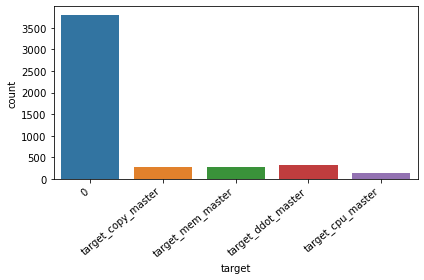

In [9]:
# Plot class distribution
print("Ploting class distribution ..")
pltdist= sns.countplot(nice_y)
pltdist.set_xticklabels(pltdist.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [10]:
print("Scaling dataset")
# scaler = StandardScaler()
# scaler = RobustScaler()
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns) # transform back to df
# Fix for lighgbm
import re
X = X.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

Scaling dataset


Starting of experiment for LightGBM only

Parameters:

boosting_type (str, optional (default='gbdt')) – ‘gbdt’, traditional Gradient Boosting Decision Tree. ‘dart’, Dropouts meet Multiple Additive Regression Trees. ‘goss’, Gradient-based One-Side Sampling. ‘rf’, Random Forest.

num_leaves (int, optional (default=31)) – Maximum tree leaves for base learners.

max_depth (int, optional (default=-1)) – Maximum tree depth for base learners, <=0 means no limit.

learning_rate (float, optional (default=0.1)) – Boosting learning rate. You can use callbacks parameter of fit method to shrink/adapt learning rate in training using reset_parameter callback. Note, that this will ignore the learning_rate argument in training.

n_estimators (int, optional (default=100)) – Number of boosted trees to fit.

subsample_for_bin (int, optional (default=200000)) – Number of samples for constructing bins.

objective (str, callable or None, optional (default=None)) – Specify the learning task and the corresponding learning objective or a custom objective function to be used (see note below). Default: ‘regression’ for LGBMRegressor, ‘binary’ or ‘multiclass’ for LGBMClassifier, ‘lambdarank’ for LGBMRanker.

class_weight (dict, 'balanced' or None, optional (default=None)) – Weights associated with classes in the form {class_label: weight}. Use this parameter only for multi-class classification task; for binary classification task you may use is_unbalance or scale_pos_weight parameters. Note, that the usage of all these parameters will result in poor estimates of the individual class probabilities. You may want to consider performing probability calibration (https://scikit-learn.org/stable/modules/calibration.html) of your model. The ‘balanced’ mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)). If None, all classes are supposed to have weight one. Note, that these weights will be multiplied with sample_weight (passed through the fit method) if sample_weight is specified.

min_split_gain (float, optional (default=0.)) – Minimum loss reduction required to make a further partition on a leaf node of the tree.

min_child_weight (float, optional (default=1e-3)) – Minimum sum of instance weight (hessian) needed in a child (leaf).

min_child_samples (int, optional (default=20)) – Minimum number of data needed in a child (leaf).

subsample (float, optional (default=1.)) – Subsample ratio of the training instance.

subsample_freq (int, optional (default=0)) – Frequency of subsample, <=0 means no enable.

colsample_bytree (float, optional (default=1.)) – Subsample ratio of columns when constructing each tree.

reg_alpha (float, optional (default=0.)) – L1 regularization term on weights.

reg_lambda (float, optional (default=0.)) – L2 regularization term on weights.

random_state (int, RandomState object or None, optional (default=None)) – Random number seed. If int, this number is used to seed the C++ code. If RandomState object (numpy), a random integer is picked based on its state to seed the C++ code. If None, default seeds in C++ code are used.

n_jobs (int, optional (default=-1)) – Number of parallel threads to use for training (can be changed at prediction time).

importance_type (str, optional (default='split')) – The type of feature importance to be filled into feature_importances_. If ‘split’, result contains numbers of times the feature is used in a model. If ‘gain’, result contains total gains of splits which use the feature.

In [11]:
# Name of experiment
# XGBoost
prefix = 'Phase1_lightgbm_evs_audsome'
paramgrid = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000],
    'max_depth': [-1, 3, 4, 6, 25, 50],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.2, 0.5, 1],
    'min_child_weight':[1, 2, 5, 6],
    'boosting_type':["gbdt", "dart", "goss"],
    'seed': [42],
    'objective': ['multiclass'],  # error evaluation for multiclass training
    # 'num_class': [len(definitions)],
}
model = lgm.sklearn.LGBMClassifier()
# model = xgb.XGBClassifier()
model.get_params().keys()

dict_keys(['boosting_type', 'class_weight', 'colsample_bytree', 'importance_type', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_split_gain', 'n_estimators', 'n_jobs', 'num_leaves', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'silent', 'subsample', 'subsample_for_bin', 'subsample_freq'])

In [12]:
#Example of HPO methods https://github.com/LiYangHart/Hyperparameter-Optimization-of-Machine-Learning-Algorithms/blob/master/HPO_Classification.ipynb
# scorer = make_scorer(accuracy_score, )
scorer = make_scorer(jaccard_score, average="micro") # TODO check average
# scorer = 'accuracy'
n_splits = 4 # default 4

cv_type = StratifiedKFold(n_splits=n_splits)
nj = 40 # Number of jobs

cv = EvolutionaryAlgorithmSearchCV(estimator=model,
                                   params=paramgrid,
                                   scoring=scorer,
                                   cv=cv_type, # StratifiedKFold not supported for multilabel-indicator (oh encoding)
                                   verbose=4,
                                   population_size=40, # 40
                                   gene_mutation_prob=0.20,
                                   gene_crossover_prob=0.5,
                                   tournament_size=4,
                                   generations_number=30, #10
                                   n_jobs=nj) # for dnn n_jobs must be set to 1 rest is 8

In [ ]:
cv.fit(X, y)

Types [1, 1, 2, 2, 1, 1, 1, 1] and maxint [6, 5, 5, 2, 3, 2, 0, 0] detected
--- Evolve in 9072 possible combinations ---
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=10, objective=multiclass, seed=42, subsample=0.5;, score=0.656 total time=  33.8s
[CV] END boosting_type=goss, learning_rate=0.2, max_depth=6, min_child_weight=6, n_estimators=10, objective=multiclass, seed=42, subsample=0.2;, score=0.597 total time=  53.8s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=10, objective=multiclass, seed=42, subsample=0.5;, score=0.656 total time=  31.4s
[CV] END boosting_type=dart, learning_rate=0.2, max_depth=-1, min_child_weight=5, n_estimators=10, objective=multiclass, seed=42, subsample=0.5;, score=0.597 total time= 1.6min
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=10, objective=multiclass, seed=42, subsample=0.5;, score=0.656 total time=  3

In [ ]:
# Remove bool values from dict
cv.cv_results_.pop('nan_test_score?')

print("Saving CV results")
file_name = "{}_hpo_best_cv.csv".format(prefix)
# with open(os.path.join(model_dir,file_name), 'w') as cvfile:
#     json.dump(cv.cv_results_, cvfile)
cv_test_scores = pd.DataFrame(cv.cv_results_)
cv_test_scores.to_csv(os.path.join(model_dir,file_name), index=False)
print("{} best params: {}".format(prefix, cv.best_params_))
param_name = "{}_hpo_best_param.json".format(prefix)
with open(os.path.join(model_dir,param_name), 'w') as cvfile:
    json.dump(cv.best_params_, cvfile)
print("{} best score: {}".format(prefix, cv.best_score_))
print("Saving best {} estimator".format(prefix))
model_name = "{}_hpo_best.joblib".format(prefix)
dump(cv.best_estimator_, os.path.join(model_dir,model_name))

In [ ]:
y_pred = cv.best_estimator_.predict(X)
custom_scoring_reporting(y_pred, y, definitions, prefix)


In [ ]:
print("Confusion matrix")
cf_matrix = confusion_matrix(y, y_pred)
plt.figure(dpi=600)
sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
cf_fig = "{}_cf.png".format(prefix)
sns_cf.figure.savefig(os.path.join(model_dir, cf_fig), format='pdf',
           bbox_inches='tight', pad_inches=0)

# Extract Feature importance
feat_importances = pd.Series(cv.best_estimator_.feature_importances_, index=list(data.drop('target', axis=1).columns))
featureimp_name = "{}_hpo_best_featureimp.csv".format(prefix)
feat_importances.to_csv(os.path.join(model_dir, featureimp_name), index=True)
# print(feat_importances.head(10))
sorted_feature = feat_importances.sort_values(ascending=True)
# Plot the feature importances of the forest
# plt.figure()
plt.figure(figsize=(10,20), dpi=600)
plt.title("Feature importances")
plt.barh(range(X.shape[1]), sorted_feature,
       color="r", align="center", )
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X.shape[1]), sorted_feature.index)
plt.ylim([-1, X.shape[1]])
plt.show()


Scoring on holdout or other dataset

In [ ]:
#Creating the dependent variable class
# factor_h = pd.factorize(df_clean['target'])
# df_clean.target = factor_h[0]
# definitions_h = factor_h[1]

In [ ]:
# print("Splitting dataset into data and ground truth ...")
# X_h = df_clean.drop('target', axis=1)
# y_h = df_clean['target']

# Scale
# X_h

In [ ]:
# X_h = scaler.transform(X_h)


In [ ]:
# y_pred_h = cv.best_estimator_.predict(X_h)
#
# custom_scoring_reporting(y_pred_h, y_h, definitions, prefix="rf_holdout")

In [ ]:
# y_pred = cv.best_estimator_.predict(X)
# custom_scoring_reporting(y_pred, y, definitions, prefix)

# jaccard_score(y_h, y_pred_h, average='micro')
# y_pred_h